# Step1：Download

In [66]:
#step1 Download
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matminer.datasets import load_dataset
from pymatgen.core import Composition

# Load the experimental band gap dataset from matminer
expt_gap = load_dataset("expt_gap")
print("Experimental Band Gap Dataset Shape:", expt_gap.shape)
print("First few rows:")
print(expt_gap.head())

# Convert the chemical formula strings into pymatgen Composition objects
expt_gap['composition'] = expt_gap['formula'].apply(lambda x: Composition(x))

# Verify the conversion by displaying the formula and the corresponding composition
print(expt_gap[['formula', 'composition']].head())

from matminer.featurizers.composition import ElementProperty

# Initialize the ElementProperty featurizer with the 'magpie' preset
ep_feat = ElementProperty.from_preset(preset_name="magpie")

# Featurize the dataset: this will add many new numerical feature columns based on the composition
features_df = ep_feat.featurize_dataframe(expt_gap, col_id="composition", ignore_errors=True)

# Display a few rows of the new feature-rich dataframe
print("Features dataframe head:")
print(features_df.head())

Experimental Band Gap Dataset Shape: (6354, 2)
First few rows:
        formula  gap expt
0  Hg0.7Cd0.3Te      0.35
1          CuBr      3.08
2           LuP      1.30
3      Cu3SbSe4      0.40
4           ZnO      3.44
        formula   composition
0  Hg0.7Cd0.3Te  (Hg, Cd, Te)
1          CuBr      (Cu, Br)
2           LuP       (Lu, P)
3      Cu3SbSe4  (Cu, Sb, Se)
4           ZnO       (Zn, O)


/home/jovyan/.local/lib/python3.9/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/6354 [00:00<?, ?it/s]

Features dataframe head:
        formula  gap expt   composition  MagpieData minimum Number  \
0  Hg0.7Cd0.3Te      0.35  (Hg, Cd, Te)                       48.0   
1          CuBr      3.08      (Cu, Br)                       29.0   
2           LuP      1.30       (Lu, P)                       15.0   
3      Cu3SbSe4      0.40  (Cu, Sb, Se)                       29.0   
4           ZnO      3.44       (Zn, O)                        8.0   

   MagpieData maximum Number  MagpieData range Number  MagpieData mean Number  \
0                       80.0                     32.0                   61.20   
1                       35.0                      6.0                   32.00   
2                       71.0                     56.0                   43.00   
3                       51.0                     22.0                   34.25   
4                       30.0                     22.0                   19.00   

   MagpieData avg_dev Number  MagpieData mode Number  \
0          

In [67]:
# Table 1: First 5 rows of the raw experimental band gap dataset
expt_gap[['formula', 'gap expt']].head().style\
    .format(precision=2)\
    .set_caption("Table 1: First 5 rows of the experimental band gap dataset")\
    .set_table_styles([
        {'selector': 'thead th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


In [68]:
# Show Table 2: Original dataset sample (formula + composition)
expt_gap[['formula', 'composition']].head().style.set_caption("Table 1: Example entries from the dataset")\
    .set_table_styles([
        {'selector': 'thead th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])

,formula,composition
0,Hg0.7Cd0.3Te,Hg0.7 Cd0.3 Te1
1,CuBr,Cu1 Br1
2,LuP,Lu1 P1
3,Cu3SbSe4,Cu3 Sb1 Se4
4,ZnO,Zn1 O1


In [69]:
# Table 3: First 5 rows of extracted Magpie features (rounded and formatted to 2 decimal places)
features_df.iloc[:, -132:].head().style\
    .format(precision=2)\
    .set_caption("Table 2: First 5 rows of extracted Magpie features (rounded to 2 decimal places)")\
    .set_table_styles([
        {'selector': 'thead th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData minimum NdUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData minimum NfUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData mode NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,48.00,80.00,32.00,61.20,13.16,52.00,70.00,90.00,20.00,80.35,9.65,90.00,112.41,200.59,88.18,150.87,34.81,127.60,234.32,722.66,488.34,532.47,208.71,722.66,12.00,16.00,4.00,14.00,2.00,16.00,5.00,6.00,1.00,5.35,0.45,5.00,132.00,1

# Step 2: Preprocessing

In [70]:
# ----- Step 2: Preprocessing-----
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

# Select features and target
X = features_df[ep_feat.feature_labels()]
y = features_df["gap expt"]

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Step 3: Exploratory Data Analysis 

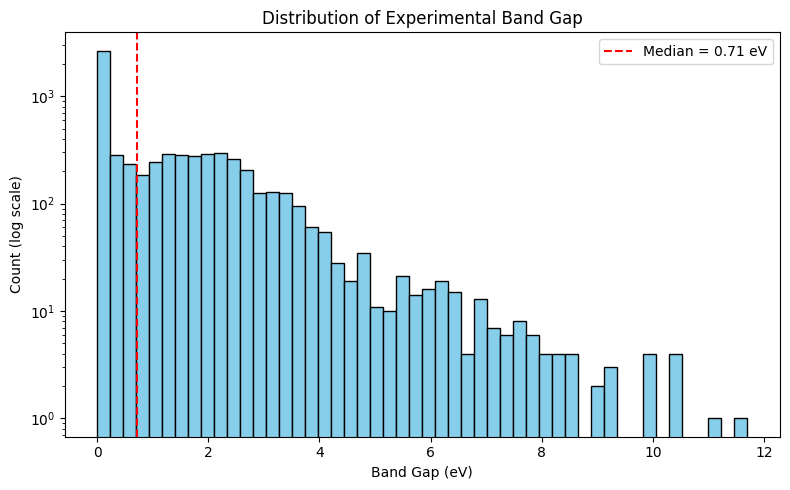

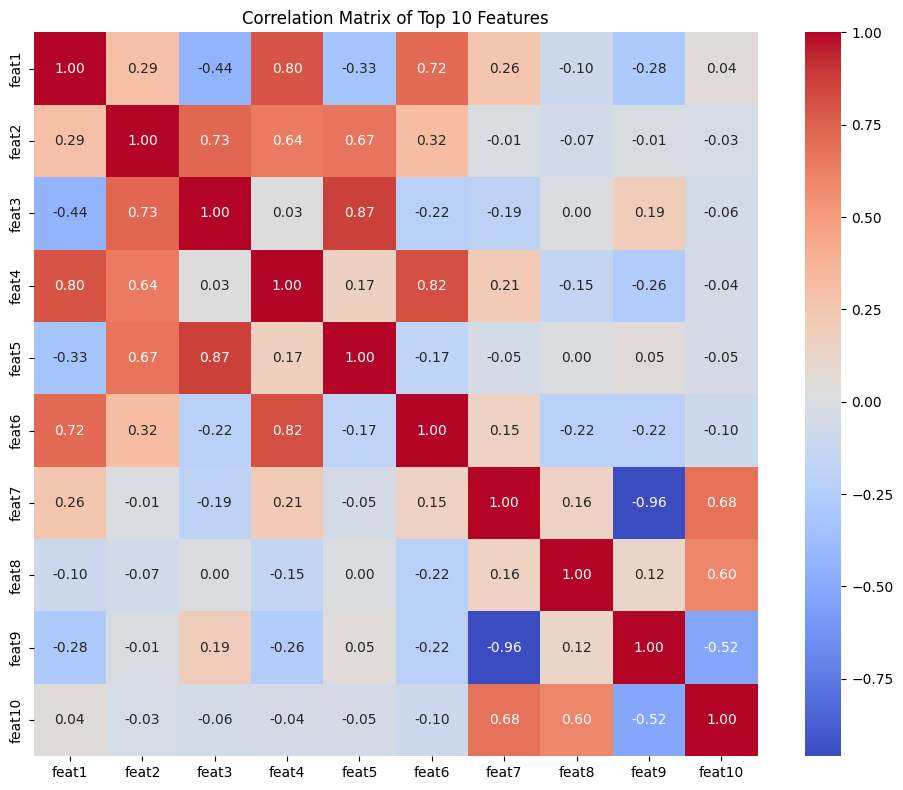

In [72]:
# ----- Step 3: Exploratory Data Analysis -----
# Band gap histogram with log y-scale and median line
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.yscale("log")
plt.axvline(y.median(), color="red", linestyle="--", label=f"Median = {y.median():.2f} eV")
plt.title("Distribution of Experimental Band Gap")
plt.xlabel("Band Gap (eV)")
plt.ylabel("Count (log scale)")
plt.legend()
plt.tight_layout()
plt.savefig("bandgap_histogram_log_median.png")
plt.show()

# Correlation heatmap of top 10 features using dynamic selection
original_labels = X_imputed.columns[:10]
short_labels = [f"feat{i+1}" for i in range(10)]
top_10_features = X_imputed[original_labels].copy()
top_10_features.columns = short_labels

corr = top_10_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlation Matrix of Top 10 Features")
plt.tight_layout()
plt.savefig("heatmap_top10_fixed.png")
plt.show()

# Step 4: Baseline Random Forest Model 

Train R²: 0.9698
Test R²: 0.7952
Test MAE: 0.3569
Test RMSE: 0.6750
Test MedAE: 0.1312


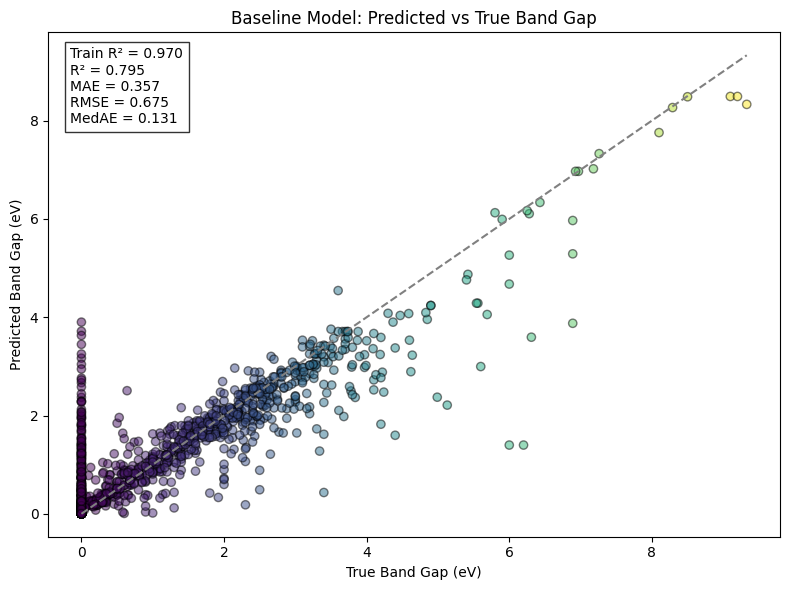

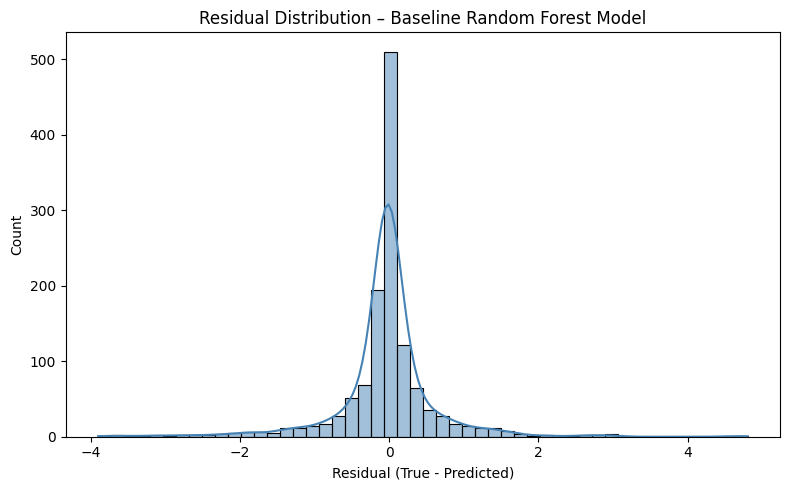

In [73]:
# ----- Step 4: Baseline Random Forest Model -----
# **Train baseline Random Forest**
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# **Predict on test and train set**
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

# **Evaluate on test set**
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

# **Evaluate on train set**
r2_train = r2_score(y_train, y_train_pred)
print(f"Train R²: {r2_train:.4f}")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MedAE: {medae:.4f}")

# **Plot 1: Predicted vs True**
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k', c=y_test, cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Baseline Model: Predicted vs True Band Gap")

# **Add annotation box (without MAPE)**
textstr = (
    f"Train R² = {r2_train:.3f}\n"
    f"R² = {r2:.3f}\n"
    f"MAE = {mae:.3f}\n"
    f"RMSE = {rmse:.3f}\n"
    f"MedAE = {medae:.3f}"
)
plt.annotate(
    textstr,
    xy=(0.03, 0.97), xycoords='axes fraction',
    fontsize=10, ha='left', va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)
plt.tight_layout()
plt.savefig("rf_baseline_pred_vs_true_annotated.png")
plt.show()

# **Plot 2: Residuals histogram**
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True, color="steelblue", edgecolor="black")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Count")
plt.title("Residual Distribution – Baseline Random Forest Model")
plt.tight_layout()
plt.savefig("rf_baseline_residuals.png")
plt.show()

# Step 5 Tuning

In [74]:
#step 5 Tuning
#cv = 5
#Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

# RandomizedSearchCV with 5-fold cross-validation
rf_model = RandomForestRegressor(random_state=42)
random_search_cv5 = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=30, cv=5, random_state=42,
    n_jobs=-1, verbose=1
)

random_search_cv5.fit(X_train, y_train)
best_model_cv5 = random_search_cv5.best_estimator_

# Evaluate performance
y_train_pred = best_model_cv5.predict(X_train)
y_test_pred = best_model_cv5.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
medae = median_absolute_error(y_test, y_test_pred)

# Print results
print("✅ Randomized search complete")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MedAE: {medae:.3f}")
print("Best Parameters:", random_search_cv5.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Randomized search complete
Train R²: 0.972
Test R²: 0.807
MAE: 0.352
RMSE: 0.656
MedAE: 0.137
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None}


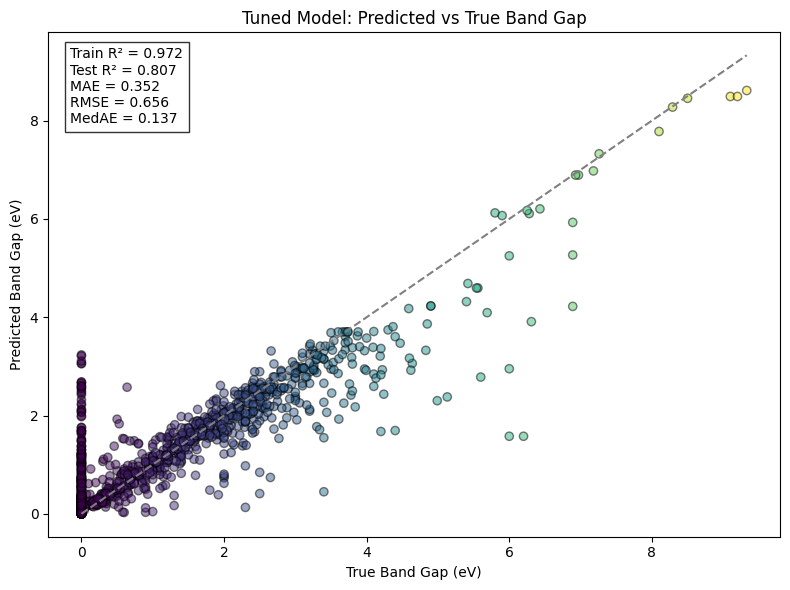

In [75]:
# === Plot: Predicted vs True for Tuned Random Forest ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolor='k', c=y_test, cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Tuned Model: Predicted vs True Band Gap")

# === Add annotation box ===
textstr = (
    f"Train R² = {train_r2:.3f}\n"
    f"Test R² = {test_r2:.3f}\n"
    f"MAE = {mae:.3f}\n"
    f"RMSE = {rmse:.3f}\n"
    f"MedAE = {medae:.3f}"
)
plt.annotate(
    textstr,
    xy=(0.03, 0.97), xycoords='axes fraction',
    fontsize=10, ha='left', va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)
plt.tight_layout()
plt.savefig("rf_tuned_pred_vs_true_annotated.png")
plt.show()

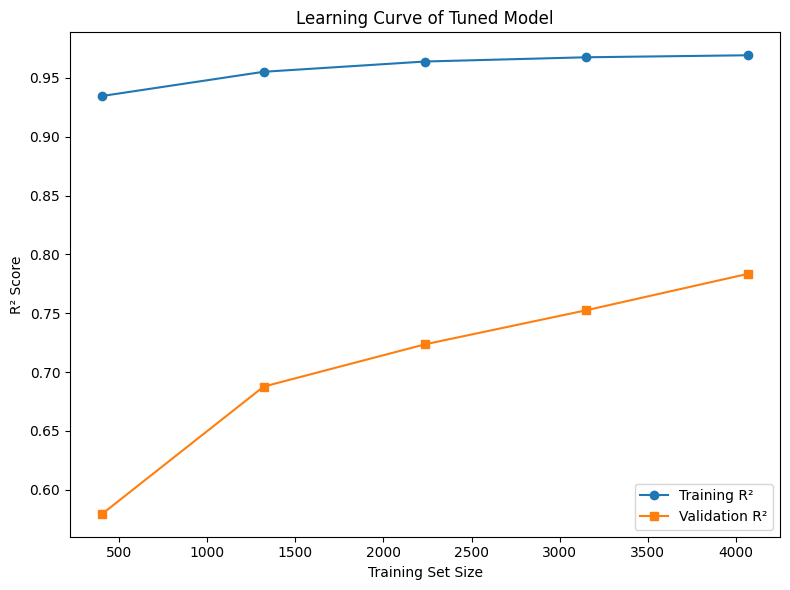

In [76]:
# **Plot 2: learning curve**
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model_cv5, X_train, y_train, cv=5, scoring="r2", n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training R²", marker='o')
plt.plot(train_sizes, test_mean, label="Validation R²", marker='s')
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve of Tuned Model")
plt.legend()
plt.tight_layout()
plt.savefig("learning_curve_tuned.png")
plt.show()

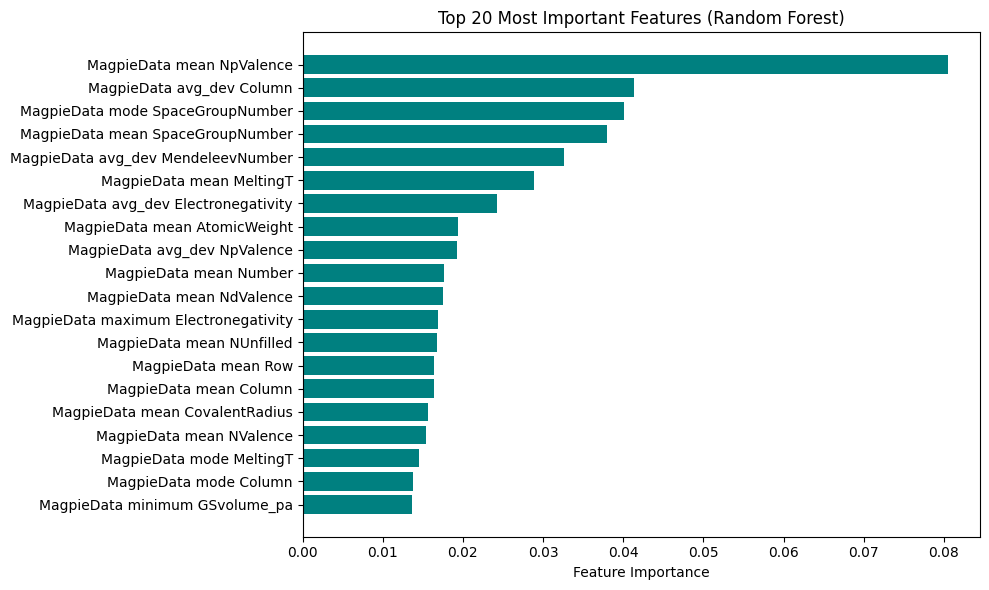

In [21]:
# **Plot 3: Importance**
# Use the best model from RandomizedSearchCV
model = random_search_cv5.best_estimator_

# Extract feature importances
importances = model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]  # Sort by importance

# Select top N features
top_n = 20
top_indices = indices[:top_n]
top_features = feature_names[top_indices]
top_importances = importances[top_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances[::-1], color='teal')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.tight_layout()
plt.savefig("plot_rf_top20_feature_importance.png")
plt.show()

# Further adjustment 1

Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Second-round RandomizedSearch complete
Train R²: 0.935
Test R²: 0.789
MAE: 0.386
RMSE: 0.684
MedAE: 0.167
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.2, 'max_depth': 15}


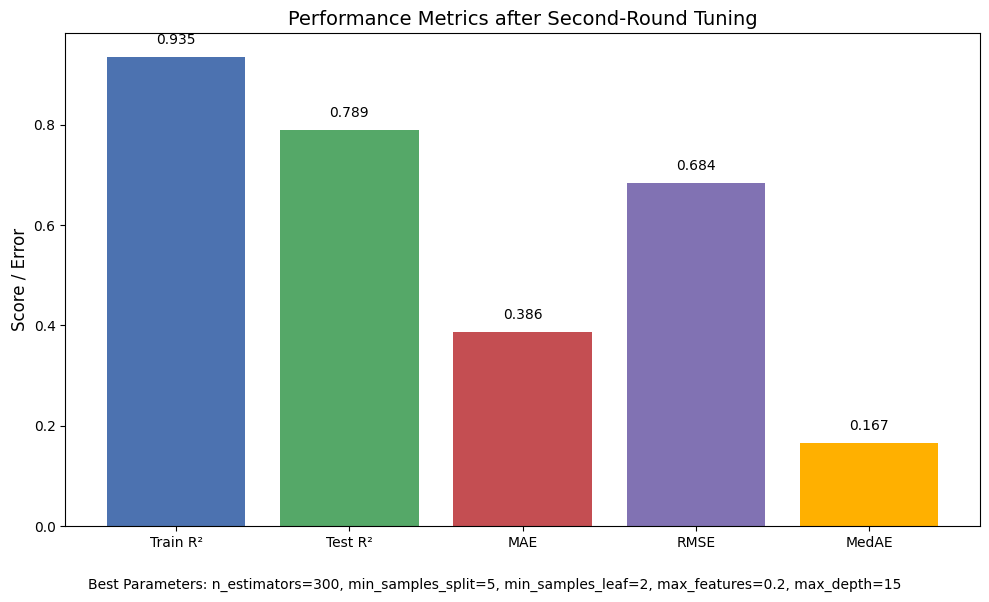

In [78]:
# Further adjustment 1
# Step 1: Define a refined and more conservative hyperparameter space
param_dist_refined = {
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': [0.2, 0.3, 'sqrt']
}

# Step 2: Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Step 3: Perform RandomizedSearchCV with 5-fold cross-validation
random_search_cv5_refined = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_refined,
    n_iter=30,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Step 4: Fit the model on training data
random_search_cv5_refined.fit(X_train, y_train)
best_model_refined = random_search_cv5_refined.best_estimator_

# Step 5: Predict and evaluate on both training and test sets
y_train_pred = best_model_refined.predict(X_train)
y_test_pred = best_model_refined.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
medae = median_absolute_error(y_test, y_test_pred)

# Step 6: Print performance metrics and best parameters
print("✅ Second-round RandomizedSearch complete")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MedAE: {medae:.3f}")
print("Best Parameters:", random_search_cv5_refined.best_params_)

# Step 7: Visualize results in a clean bar chart
metrics = ["Train R²", "Test R²", "MAE", "RMSE", "MedAE"]
values = [train_r2, test_r2, mae, rmse, medae]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#FFB000'])

# Annotate bars with their exact values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.3f}",
             ha='center', va='bottom', fontsize=10)

plt.title("Performance Metrics after Second-Round Tuning", fontsize=14)
plt.ylabel("Score / Error", fontsize=12)
plt.grid(False)  # Remove gridlines for cleaner presentation

# Display best parameter combination below the chart
param_str = ', '.join([f"{k}={v}" for k, v in random_search_cv5_refined.best_params_.items()])
plt.figtext(0.5, 0.01, f"Best Parameters: {param_str}", wrap=True,
            ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Reserve space at bottom for parameter text
plt.savefig("Round 2 Adjustment")
plt.show()

# Further adjustment 2

Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Third-round RandomizedSearch complete (Increased Complexity)
Train R²: 0.972
Test R²: 0.807
MAE: 0.356
RMSE: 0.656
MedAE: 0.137
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


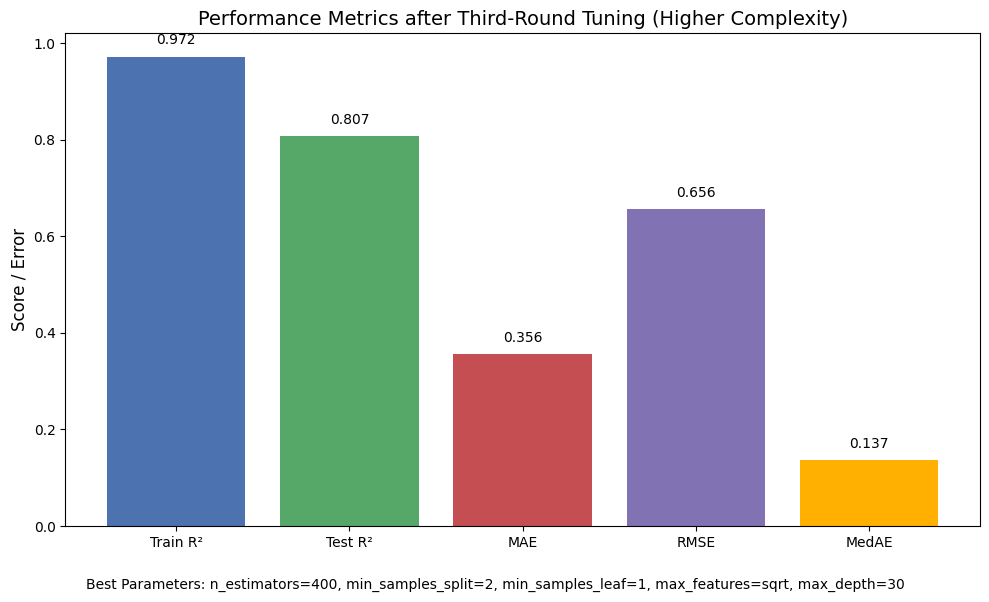

In [79]:
# Further adjustment 2
# Step 1: Define a hyperparameter space with increased model complexity
param_dist_complex = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None, 25, 30],              # Allow deeper trees or no depth limit
    'min_samples_split': [2, 3],              # Looser constraints on splitting
    'min_samples_leaf': [1],                  # Allow very small leaf nodes
    'max_features': ['sqrt', 0.5, 0.7]        # Allow more features per split
}

# Step 2: Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Step 3: Perform RandomizedSearchCV with 5-fold cross-validation
random_search_cv5_complex = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_complex,
    n_iter=30,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Step 4: Fit the model on training data
random_search_cv5_complex.fit(X_train, y_train)
best_model_complex = random_search_cv5_complex.best_estimator_

# Step 5: Predict and evaluate on both training and test sets
y_train_pred = best_model_complex.predict(X_train)
y_test_pred = best_model_complex.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
medae = median_absolute_error(y_test, y_test_pred)

# Step 6: Print performance metrics and best parameters
print("✅ Third-round RandomizedSearch complete (Increased Complexity)")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MedAE: {medae:.3f}")
print("Best Parameters:", random_search_cv5_complex.best_params_)

# Step 7: Visualize results in a clean bar chart
metrics = ["Train R²", "Test R²", "MAE", "RMSE", "MedAE"]
values = [train_r2, test_r2, mae, rmse, medae]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#FFB000'])

# Annotate bars with their exact values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.3f}",
             ha='center', va='bottom', fontsize=10)

plt.title("Performance Metrics after Third-Round Tuning (Higher Complexity)", fontsize=14)
plt.ylabel("Score / Error", fontsize=12)
plt.grid(False)

# Display best parameter combination below the chart
param_str = ', '.join([f"{k}={v}" for k, v in random_search_cv5_complex.best_params_.items()])
plt.figtext(0.5, 0.01, f"Best Parameters: {param_str}", wrap=True,
            ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("Round 3 Adjustment")
plt.show()

# Step 5 cv = 3

In [80]:
#step 5 
#cv = 3
#Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

# RandomizedSearchCV with 3-fold cross-validation
rf_model = RandomForestRegressor(random_state=42)
random_search_cv3 = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=30, cv=3, random_state=42,
    n_jobs=-1, verbose=1
)
random_search_cv3.fit(X_train, y_train)
best_model_cv3 = random_search_cv3.best_estimator_

# Evaluate performance
y_train_pred = best_model_cv3.predict(X_train)
y_test_pred = best_model_cv3.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
medae = median_absolute_error(y_test, y_test_pred)

# Print results
print("✅ Randomized search complete")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MedAE: {medae:.3f}")
print("Best Parameters:", random_search_cv3.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Randomized search complete
Train R²: 0.972
Test R²: 0.807
MAE: 0.352
RMSE: 0.656
MedAE: 0.137
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None}


# Step 5 cv = 10

In [81]:
#step 5 
#cv = 10
#Define hyperparameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

# RandomizedSearchCV with 3-fold cross-validation
rf_model = RandomForestRegressor(random_state=42)
random_search_cv10 = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=30, cv=10, random_state=42,
    n_jobs=-1, verbose=1
)
random_search_cv10.fit(X_train, y_train)
best_model_cv10 = random_search_cv10.best_estimator_

# Evaluate performance
y_train_pred = best_model_cv10.predict(X_train)
y_test_pred = best_model_cv10.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
medae = median_absolute_error(y_test, y_test_pred)

# Print results
print("✅ Randomized search complete")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MedAE: {medae:.3f}")
print("Best Parameters:", random_search_cv10.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
✅ Randomized search complete
Train R²: 0.972
Test R²: 0.807
MAE: 0.352
RMSE: 0.656
MedAE: 0.137
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None}


# Step 5 GridSearchCV

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
✅ Grid search complete
Train R²: 0.972
Test R²: 0.806
MAE: 0.352
RMSE: 0.657
MedAE: 0.138
Best Parameters: {'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


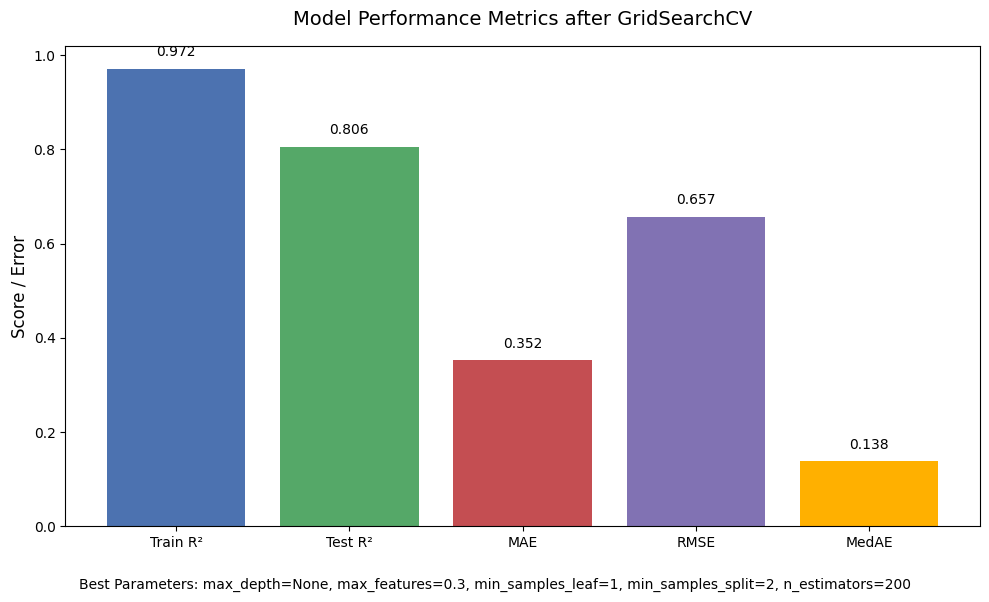

In [84]:
#step 5 GridSearchCV
from sklearn.model_selection import GridSearchCV
# Define hyperparameter grid 
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# GridSearchCV with 5-fold cross-validation
grid_search_cv5 = GridSearchCV(
    rf_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)


# Fit the model
grid_search_cv5.fit(X_train, y_train)
best_model_cv5 = grid_search_cv5.best_estimator_

# Predict and evaluate
y_train_pred = best_model_cv5.predict(X_train)
y_test_pred = best_model_cv5.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
medae = median_absolute_error(y_test, y_test_pred)

# Output results
print("✅ Grid search complete")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MedAE: {medae:.3f}")
print("Best Parameters:", grid_search_cv5.best_params_)

# Define metrics and values to plot
metrics = ["Train R²", "Test R²", "MAE", "RMSE", "MedAE"]
values = [train_r2, test_r2, mae, rmse, medae]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#FFB000'])

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.3f}",
             ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title("Model Performance Metrics after GridSearchCV", fontsize=14, pad=15)
plt.ylabel("Score / Error", fontsize=12)

# Remove grid
plt.grid(False)

# Display best parameters below the plot
param_str = ', '.join([f"{k}={v}" for k, v in grid_search_cv5.best_params_.items()])
plt.figtext(0.5, 0.01, f"Best Parameters: {param_str}", wrap=True,
            ha='center', fontsize=10)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("GridSearchCV")
plt.show()

# Step 5 PCA

Fitting 5 folds for each of 30 candidates, totalling 150 fits
✅ Model evaluation with PCA (10 components):
Train R²: 0.955
Test R²: 0.702
MAE: 0.468
RMSE: 0.814
MedAE: 0.188
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None}


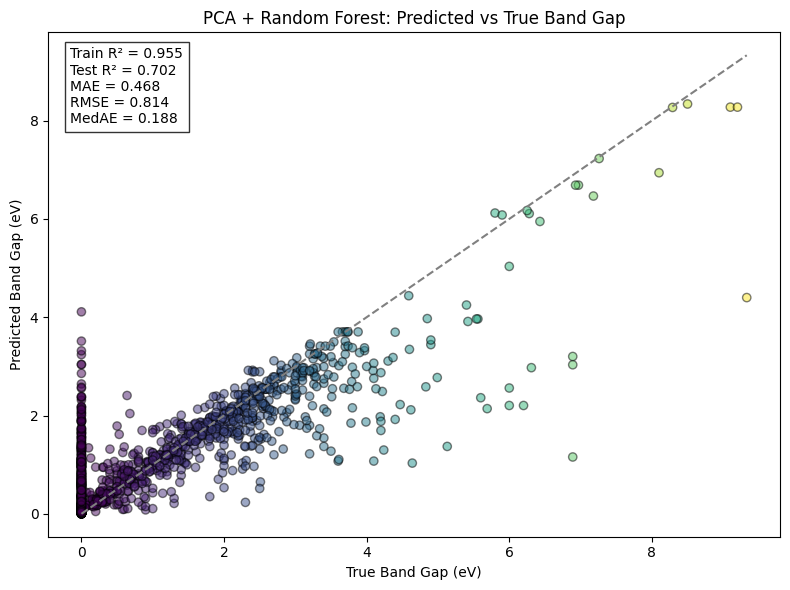

In [83]:
#step 5 PCA
from sklearn.decomposition import PCA
# === (1) Select top 20 important features ===
top_20_features = [
    'MagpieData mean NpValence', 'MagpieData avg_dev Column', 'MagpieData mode SpaceGroupNumber',
    'MagpieData mean SpaceGroupNumber', 'MagpieData avg_dev MendeleevNumber', 'MagpieData mean MeltingT',
    'MagpieData avg_dev Electronegativity', 'MagpieData mean AtomicWeight', 'MagpieData avg_dev NpValence',
    'MagpieData mean Number', 'MagpieData mean NdValence', 'MagpieData maximum Electronegativity',
    'MagpieData mean NUnfilled', 'MagpieData mean Row', 'MagpieData mean Column',
    'MagpieData mean CovalentRadius', 'MagpieData mean NValence', 'MagpieData mode MeltingT',
    'MagpieData mode Column', 'MagpieData minimum GSvolume_pa'
]

X_top20 = X_imputed[top_20_features]
y = features_df["gap expt"]

# === (2) PCA with 10 components ===
pca = PCA(n_components=10)
X_pca_10 = pca.fit_transform(X_top20)

# === (3) Train-test split ===
X_train_pca10, X_test_pca10, y_train_pca10, y_test_pca10 = train_test_split(
    X_pca_10, y, test_size=0.2, random_state=42)

# === (4) RandomizedSearchCV with Random Forest ===
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

rf_model = RandomForestRegressor(random_state=42)
random_search_pca10 = RandomizedSearchCV(
    rf_model, param_distributions=param_dist,
    n_iter=30, cv=5, random_state=42, n_jobs=-1, verbose=1
)
random_search_pca10.fit(X_train_pca10, y_train_pca10)

# === (5) Evaluate PCA model ===
best_model_pca = random_search_pca10.best_estimator_
y_train_pred_pca = best_model_pca.predict(X_train_pca10)
y_test_pred_pca = best_model_pca.predict(X_test_pca10)

train_r2_pca = r2_score(y_train_pca10, y_train_pred_pca)
test_r2_pca = r2_score(y_test_pca10, y_test_pred_pca)
mae_pca = mean_absolute_error(y_test_pca10, y_test_pred_pca)
rmse_pca = mean_squared_error(y_test_pca10, y_test_pred_pca) ** 0.5
medae_pca = median_absolute_error(y_test_pca10, y_test_pred_pca)

print("✅ Model evaluation with PCA (10 components):")
print(f"Train R²: {train_r2_pca:.3f}")
print(f"Test R²: {test_r2_pca:.3f}")
print(f"MAE: {mae_pca:.3f}")
print(f"RMSE: {rmse_pca:.3f}")
print(f"MedAE: {medae_pca:.3f}")
print("Best Parameters:", random_search_pca10.best_params_)

# === (6) Visualization ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pca10, y_test_pred_pca, alpha=0.5, edgecolor='k', c=y_test_pca10, cmap='viridis')
plt.plot([y_test_pca10.min(), y_test_pca10.max()], [y_test_pca10.min(), y_test_pca10.max()],
         color='gray', linestyle='--')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("PCA + Random Forest: Predicted vs True Band Gap")

# Annotation box
textstr = (
    f"Train R² = {train_r2_pca:.3f}\n"
    f"Test R² = {test_r2_pca:.3f}\n"
    f"MAE = {mae_pca:.3f}\n"
    f"RMSE = {rmse_pca:.3f}\n"
    f"MedAE = {medae_pca:.3f}"
)
plt.annotate(
    textstr,
    xy=(0.03, 0.97), xycoords='axes fraction',
    fontsize=10, ha='left', va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)
plt.tight_layout()
plt.savefig("pca_rf_pred_vs_true_annotated.png")
plt.show()

# Step 5 split

✅ Sample sizes:
Training - Low-Gap (≤ 1.5 eV): 3216 samples
Training - High-Gap (> 1.5 eV): 1867 samples
Test     - Low-Gap (≤ 1.5 eV): 808 samples
Test     - High-Gap (> 1.5 eV): 463 samples



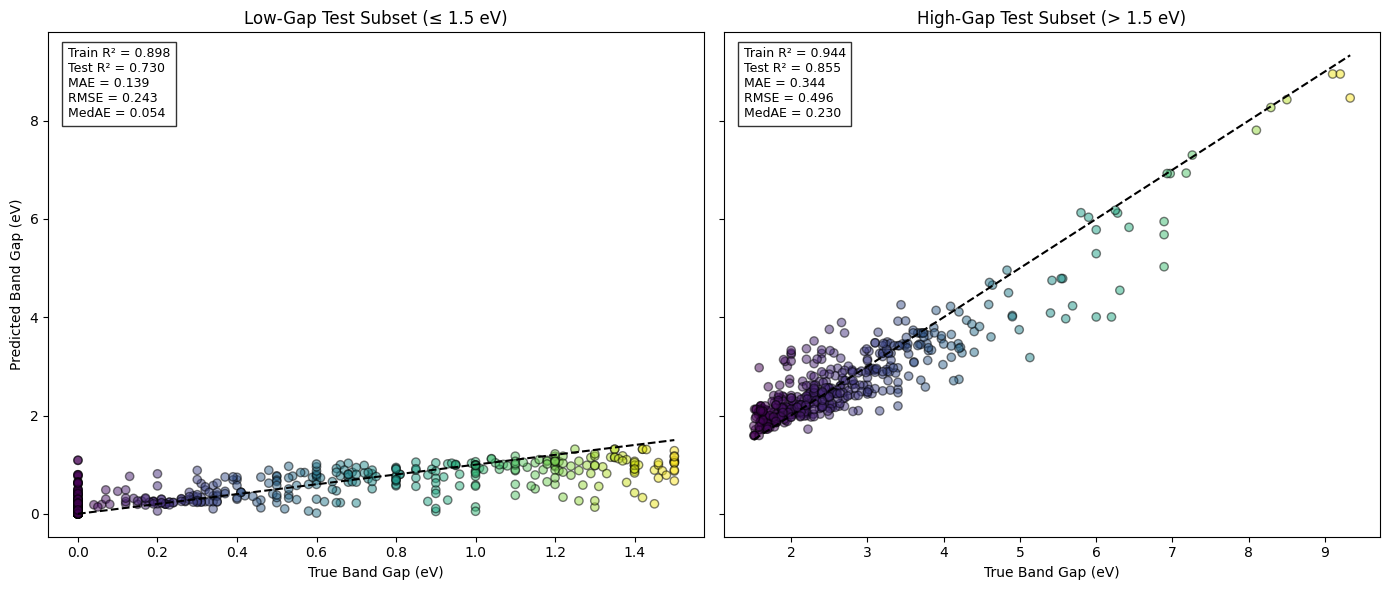

In [85]:
#step 5 split
# Step 0: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Use 1.5 eV as the boundary to create low-gap and high-gap masks
low_gap_mask = y_train <= 1.5
high_gap_mask = y_train > 1.5
low_gap_test_mask = y_test <= 1.5
high_gap_test_mask = y_test > 1.5

# Step 2: Subset training and test data
X_low, y_low = X_train[low_gap_mask], y_train[low_gap_mask]
X_high, y_high = X_train[high_gap_mask], y_train[high_gap_mask]
X_test_low, y_test_low = X_test[low_gap_test_mask], y_test[low_gap_test_mask]
X_test_high, y_test_high = X_test[high_gap_test_mask], y_test[high_gap_test_mask]

# Step 3: Print sample sizes for documentation
print("✅ Sample sizes:")
print(f"Training - Low-Gap (≤ 1.5 eV): {len(y_low)} samples")
print(f"Training - High-Gap (> 1.5 eV): {len(y_high)} samples")
print(f"Test     - Low-Gap (≤ 1.5 eV): {len(y_test_low)} samples")
print(f"Test     - High-Gap (> 1.5 eV): {len(y_test_high)} samples\n")

# Step 4: Define Random Forest parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Step 5: Train Random Forest model on low-gap subset
rf_low = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
rf_low.fit(X_low, y_low)
y_train_pred_low = rf_low.predict(X_low)
y_test_pred_low = rf_low.predict(X_test_low)

# Step 6: Train Random Forest model on high-gap subset
rf_high = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
rf_high.fit(X_high, y_high)
y_train_pred_high = rf_high.predict(X_high)
y_test_pred_high = rf_high.predict(X_test_high)

# Step 7: Plot side-by-side results
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# === Left: Low-gap subset ===
axes[0].scatter(y_test_low, y_test_pred_low, alpha=0.5, edgecolor='k', c=y_test_low, cmap='viridis')
axes[0].plot([y_test_low.min(), y_test_low.max()], [y_test_low.min(), y_test_low.max()], 'k--')
axes[0].set_title("Low-Gap Test Subset (≤ 1.5 eV)")
axes[0].set_xlabel("True Band Gap (eV)")
axes[0].set_ylabel("Predicted Band Gap (eV)")
text_low = (
    f"Train R² = {r2_score(y_low, y_train_pred_low):.3f}\n"
    f"Test R² = {r2_score(y_test_low, y_test_pred_low):.3f}\n"
    f"MAE = {mean_absolute_error(y_test_low, y_test_pred_low):.3f}\n"
    f"RMSE = {mean_squared_error(y_test_low, y_test_pred_low) ** 0.5:.3f}\n"
    f"MedAE = {median_absolute_error(y_test_low, y_test_pred_low):.3f}"
)
axes[0].annotate(text_low, xy=(0.03, 0.97), xycoords='axes fraction',
                 fontsize=9, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=0.8))

# === Right: High-gap subset ===
axes[1].scatter(y_test_high, y_test_pred_high, alpha=0.5, edgecolor='k', c=y_test_high, cmap='viridis')
axes[1].plot([y_test_high.min(), y_test_high.max()], [y_test_high.min(), y_test_high.max()], 'k--')
axes[1].set_title("High-Gap Test Subset (> 1.5 eV)")
axes[1].set_xlabel("True Band Gap (eV)")
text_high = (
    f"Train R² = {r2_score(y_high, y_train_pred_high):.3f}\n"
    f"Test R² = {r2_score(y_test_high, y_test_pred_high):.3f}\n"
    f"MAE = {mean_absolute_error(y_test_high, y_test_pred_high):.3f}\n"
    f"RMSE = {mean_squared_error(y_test_high, y_test_pred_high) ** 0.5:.3f}\n"
    f"MedAE = {median_absolute_error(y_test_high, y_test_pred_high):.3f}"
)
axes[1].annotate(text_high, xy=(0.03, 0.97), xycoords='axes fraction',
                 fontsize=9, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig("pred_vs_true_low_vs_high_gap_1p5.png")
plt.show()

# Step 5 band gap > 0

Fitting 5 folds for each of 30 candidates, totalling 150 fits


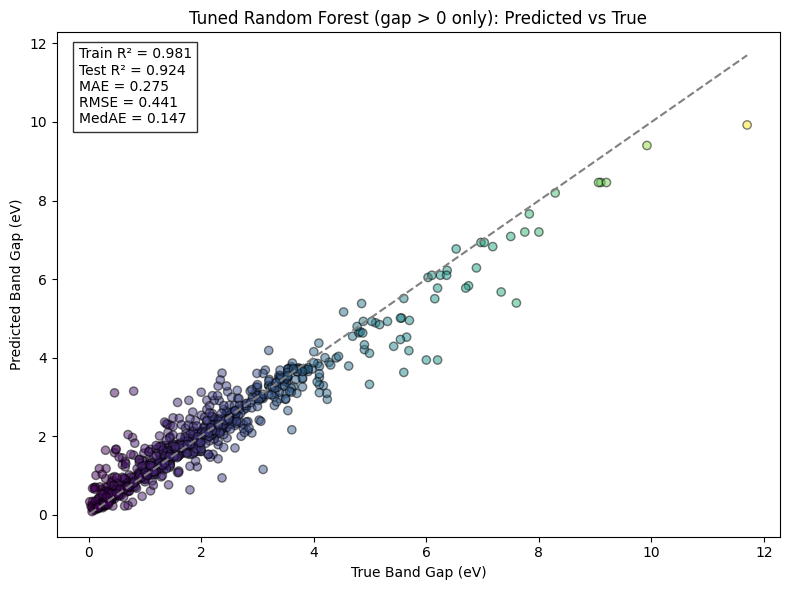

✅ Best Parameters from RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None}


In [86]:
#step 5 band gap > 0
# === Step 1: Filter non-metal samples (band gap > 0) ===
X = X[y > 0]  # Feature matrix (e.g. top 20 features)
y = y[y > 0]  # Target band gap values

# === Step 2: Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Step 3: Define hyperparameter search space ===
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 0.3, 0.5]
}

# === Step 4: Randomized hyperparameter search ===
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search.fit(X_train, y_train)

# === Step 5: Use best model from tuning ===
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# === Step 6: Evaluate model performance ===
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
medae = median_absolute_error(y_test, y_test_pred)

# === Step 7: Visualization ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolor='k', c=y_test, cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Tuned Random Forest (gap > 0 only): Predicted vs True")

# Add annotation box with performance metrics
textstr = (
    f"Train R² = {train_r2:.3f}\n"
    f"Test R² = {test_r2:.3f}\n"
    f"MAE = {mae:.3f}\n"
    f"RMSE = {rmse:.3f}\n"
    f"MedAE = {medae:.3f}"
)
plt.annotate(
    textstr,
    xy=(0.03, 0.97), xycoords='axes fraction',
    fontsize=10, ha='left', va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.tight_layout()
plt.savefig("rf_random_search_tuned_pred_vs_true.png")
plt.show()

# === Step 8: Output best parameters ===
print("✅ Best Parameters from RandomizedSearchCV:")
print(random_search.best_params_)